In [1]:
# Overview of progress ( google API by country)  of vaccination (VS Death rate ) top 25 countries & Australia


In [1]:
#dependencies 
import pandas as pd 
from matplotlib import pyplot as plt 
from matplotlib.ticker import FuncFormatter
import plotly.express as px
from scipy import stats
import numpy as np
from scipy.stats import linregress
import datetime

In [12]:
# read csv file with vaccination data  and convert to dataframe 
file="Resources/owid-covid-data.csv"
vacc=pd.read_csv(file)

#groupby country and get percentage of fully vacc & firstdose per hundred 
# as data gets updated as per time, hence the max will be the latest vaccination rate per hundred 
firstdose=vacc.groupby('location')['people_vaccinated_per_hundred'].max()
fully_vacc=vacc.groupby('location')['people_fully_vaccinated_per_hundred'].max()
country_code=vacc.groupby('location')['iso_code'].first()
total_cases_per_million=vacc.groupby('location')['total_cases_per_million'].max()
#create new dataframe with vacc progress (first, fully, not vacc )
vacc_details=pd.DataFrame({"First Dose": round(firstdose/100,2),
                           "Fully Vaccinated": round(fully_vacc/100,2),
                           "Not Vaccinated":"",
                           "Country code": country_code ,
                           "Death Rate":round(total_cases_per_million/10000,2)
                          
                          })

# clean data by dropping n/a and remove people vaccinated>100 per hundred (invalid data)
vacc_clean=vacc_details.loc[vacc_details['First Dose']<=1].dropna()

# calculate value of people not vaccinated and update df (100-people receive first dose)
vacc_clean['Not Vaccinated']=1-vacc_clean['First Dose']
# randomly choose or top 24
#1 vacc_progress=vacc_clean.sample(n=24)
vacc_progress=vacc_clean.nlargest(24,'First Dose') 
#vacc_progress.to_csv("output/test.csv")
#pd.options.display.float_format = '{:.2%}'.format

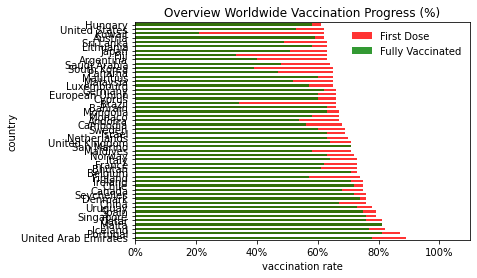

In [6]:
# plotting stack bar chart 
ax=vacc_progress['First Dose'].plot(kind='barh', color='red', width=.5, alpha=0.8)
vacc_progress['Fully Vaccinated'].plot(kind='barh', color='green', width=.5, alpha=0.8)
#setting range of x axis and format it as % 
ax.set_xlim(0, 1.1)
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
#adding labels 
#legend.loc="lower right"
ax.set_xlabel('vaccination rate')
ax.set_ylabel('country')
ax.set_title('Overview Worldwide Vaccination Progress (%)')
ax.legend(loc='best', frameon=False)

In [4]:
vacc_clean.head()

,First Dose,Fully Vaccinated,Not Vaccinated,Country code,Death Rate
location,,,,,
Afghanistan,0.02,0.01,0.98,AFG,0.39
Africa,0.06,0.03,0.94,OWID_AFR,0.59
Albania,0.31,0.24,0.69,ALB,5.47
Algeria,0.11,0.07,0.89,DZA,0.45
Andorra,0.67,0.54,0.33,AND,19.50


In [11]:
vacc_clean.reset_index(level=0, inplace=True)

fig = px.choropleth(vacc_clean, locations=vacc_clean['Country code'],
                    color=vacc_clean['First Dose'],
                    hover_name=vacc_clean['location'],
                    color_continuous_scale="Viridis",
                    range_color=(0, 1),
                    labels={'First Dose':'First Dose rate'},
                    
                   )
fig.update_layout(
    title_text='Global Vaccincation Progress Overview', 
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
     text='Source: <a href="https://ourworldindata.org/covid-vaccinations">Our World in Data</a>',
        showarrow = False
    )]
)


fig.show()

In [6]:
#prediction on fully vaccination ( Australia 95% )
#getting raw data of australia 
vacc_au=vacc.loc[vacc['location'] =='Australia']

#drop missing value in vaccination columns 
vacc_au_clean=vacc_au.dropna(subset=['people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred'])

#convert date column to datetime type 
vacc_au_clean['date']= pd.to_datetime(vacc_au_clean['date'])

 #convert the dates or timestamps to an integer number of days since the start of the data so we can build up liner regression   
vacc_au_clean['converted_time'] = (vacc_au_clean['date'] - vacc_au_clean['date'].min())  / np.timedelta64(1,'D')
vacc_au_clean

<ipython-input-6-fb40ac9a210b>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-6-fb40ac9a210b>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality,converted_time
6574,AUS,Oceania,Australia,2021-05-24,30029.0,10.0,6.571,910.0,0.0,0.000,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,0.0
6575,AUS,Oceania,Australia,2021-05-25,30046.0,17.0,7.714,910.0,0.0,0.000,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,1.0
6576,AUS,Oceania,Australia,2021-05-26,30063.0,17.0,9.714,910.0,0.0,0.000,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,2.0
6577,AUS,Oceania,Australia,2021-05-27,30074.0,11.0,10.714,910.0,0.0,0.000,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,3.0
6578,AUS,Oceania,Australia,2021-05-28,30083.0,9.0,11.429,910.0,0.0,0.000,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6681,AUS,Oceania,Australia,2021-09-08,68042.0,1725.0,1640.286,1066.0,6.0,6.714,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,107.0
6682,AUS,Oceania,Australia,2021-09-09,69912.0,1870.0,1672.000,1076.0,10.0,6.286,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,108.0
6683,AUS,Oceania,Australia,2021-09-10,71987.0,2075.0,1719.714,1084.0,8.0,6.857,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,109.0
6684,AUS,Oceania,Australia,2021-09-11,73603.0,1616.0,1712.000,1091.0,7.0,7.429,...,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,110.0


Preduction on Australia being vaccinated (first dose) 
1. Assuming 95% is the goal of whole country being vaccinated 
2. Assuming there is no supply issue 
when y=0.95, x=243, which means it will be 243 days from the start date( 2021.5.24 in our dataset), we would achieve this by Saturday, 22 January 2022


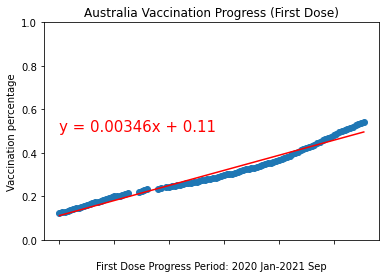

In [7]:
#scatter plot then liner regression to run prediction 
# x is time, y is vaccination rate (first dose)

x=vacc_au_clean['converted_time']
y1=vacc_au_clean['people_vaccinated_per_hundred']/100

# hide the x ticks as the timeframe is big 
plt.xticks(color='w')

#set y limits 
plt.ylim(0,1)

#plotting
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y1)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,2))
plt.scatter(x,y1)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq,(0,0.5),fontsize=15,color="red")
plt.xlabel("First Dose Progress Period: 2020 Jan-2021 Sep")
plt.ylabel("Vaccination percentage")
plt.title('Australia Vaccination Prediction (First Dose)')
plt.show()

Preduction on Australia being fully vaccinated 
1. Assuming 95% is the goal of whole country being vaccinated 
2. Assuming there is no supply issue 
when y=0.95, x=334,  which means it will be 334 days from the start date( 2021.5.24 in our dataset), we would achieve this by Saturday, 23 April 2022

<function matplotlib.pyplot.show(close=None, block=None)>

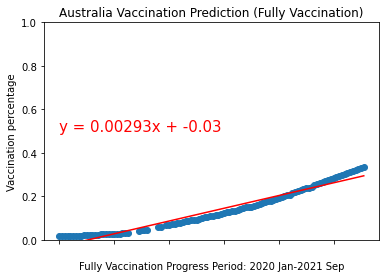

In [13]:
#scatter plot then liner regression to run prediction 
# x is time, y is vaccination rate (fully vaccination)
x=vacc_au_clean['converted_time']
y2=vacc_au_clean['people_fully_vaccinated_per_hundred']/100

# hide the x ticks as the timeframe is big 
plt.xticks(color='w')

#set y limits
plt.ylim(0,1)

#plotting 
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y2)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,2))
plt.scatter(x,y2)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq,(0,0.5),fontsize=15,color="red")
plt.xlabel("Fully Vaccination Progress Period: 2020 Jan-2021 Sep")
plt.ylabel("Vaccination percentage")
plt.title('Australia Vaccination Prediction (Fully Vaccination)')
plt.show